In [152]:
import tifffile
import pandas as pd
import joblib as jb
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap
from pathlib import Path

In [45]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [90]:
# Select collections
intertidal_dataset = ee.ImageCollection('UQ/murray/Intertidal/v1_1/global_intertidal');
sentinel_dataset  = ee.ImageCollection("COPERNICUS/S2_SR")

In [91]:
# Create ROI
feature = Map.draw_last_feature
roi = feature.geometry()

In [92]:
# Add intertidal zone to visualization
visualization = {
  'bands': ['classification'],
  'min': 0.0,
  'max': 1.0,
  'palette': ['0000FF']
}
Map.centerObject(roi);
Map.addLayer(dataset, visualization, 'Intertidal areas');

In [93]:
# Get intertidal data filtered by roi - This data is from 1984 to 2016 with tidal variation from 2 years observations
intertidal_roi = intertidal_dataset.filterBounds(roi)
count_intertidal = intertidal_roi.size()
print('Count: ', str(count_intertidal.getInfo())+'\n')

Count:  11



In [ ]:
# Save intertal masks
geemap.ee_export_image_collection(collection_roi, out_dir='./intertidal_data/masks/', scale=25, file_per_band=False, region=roi)

In [104]:
# Get sentinel-2 data filtered by date and selecting b1-b8
start_date = '2018-01-01'
end_date = '2020-01-01'
sentinel_roi = sentinel_dataset.filterBounds(roi).filterDate(start_date, end_date).select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])
# Filter sentinel data by cloud
filtered_sentinel = sentinel_roi.filterMetadata('CLOUD_COVERAGE_ASSESSMENT', 'less_than', 15)

count_sentinel = filtered_sentinel.size()
print('Count: ', str(count_sentinel.getInfo())+'\n')

Count:  26



In [ ]:
# Export sentinel data clipping roi
geemap.ee_export_image_collection(filtered, out_dir='./intertidal_data/timeseries/', scale=25, file_per_band=True, region=roi)

In [161]:
import tifffile
from glob import glob
import utm

In [78]:
path = './intertidal_data/*'
paths = [e for e in glob(path)]
paths

['./intertidal_data/1996-1998.tif',
 './intertidal_data/2014-2016.tif',
 './intertidal_data/1999-2001.tif',
 './intertidal_data/2002-2004.tif',
 './intertidal_data/2011-2013.tif',
 './intertidal_data/1993-1995.tif',
 './intertidal_data/1984-1986.tif',
 './intertidal_data/2008-2010.tif',
 './intertidal_data/1987-1989.tif',
 './intertidal_data/2005-2007.tif',
 './intertidal_data/1990-1992.tif']

In [109]:
tiff = tifffile.TiffFile('./intertidal_data/masks/1987-1989.tif')

In [110]:
arr = tiff.asarray()

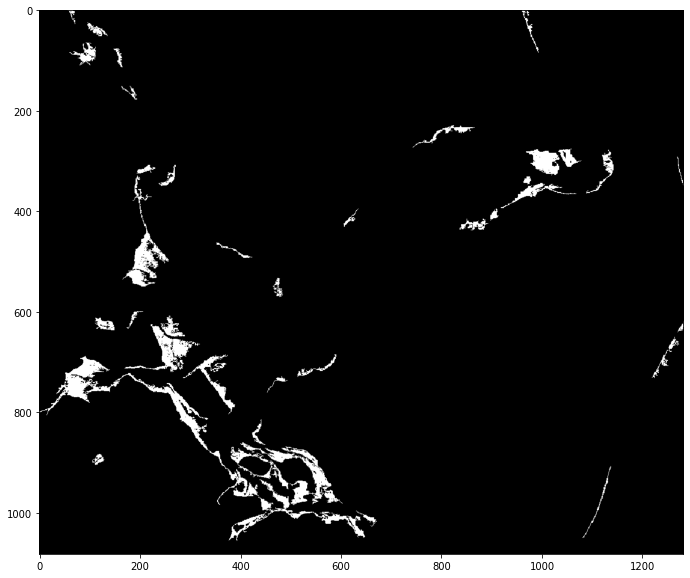

In [157]:
plt.figure(figsize=(18, 10))
plt.imshow(arr, 'gray')

In [187]:
aux_dict = dict()
for page in tiff.pages:
    for tag in page.tags.values():
        aux_dict[tag.name] = tag.value


In [162]:
start_lat = aux_dict['ModelTransformationTag'][7]
start_long = aux_dict['ModelTransformationTag'][3]

In [169]:
utm_lat, utm_long, _, _ = utm.from_latlon(start_lat, start_long)
utm_lat, utm_long

(718728.1021795371, 7107878.914210094)

In [184]:
img_test = tifffile.TiffFile('./intertidal_data/timeseries/20181216T132221_20181216T132224_T22JGR.B1.tif')

aux_img_dict = dict()
for page in img_test.pages:
    for tag in page.tags.values():
        aux_img_dict[tag.name] = tag.value
img_start_x = aux_img_dict['ModelTransformationTag'][3]
img_start_y = aux_img_dict['ModelTransformationTag'][7]

In [ ]:
aux_img_dict